In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB1
from keras.models import Model

from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from keras.layers.advanced_activations import PReLU, LeakyReLU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics

from PIL import Image
import os

In [ ]:
train_data_dir = '/content/drive/MyDrive/FL/plant_disease/Plants_2/train'
val_data_dir = '/content/drive/MyDrive/FL/plant_disease/Plants_2/valid'
test_data_dir = '/content/drive/MyDrive/FL/plant_disease/Plants_2/test'

img_width = 224
img_height = 224
batch_size = 32

# Augmentation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8,1.2],
    )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8,1.2],
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=19
    )

validation_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=19
    )

test_generator = val_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=19
    )

Found 4185 images belonging to 22 classes.
Found 110 images belonging to 22 classes.
Found 110 images belonging to 22 classes.


In [ ]:
class CreateModel:
  def __init__(self, pre_train_model, model_name):
    pre_train_model.trainable = False
    last_output = pre_train_model.output
    x = Flatten()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(22, activation='softmax')(x)

    # Define optimizer, learning rate and loss function
    self.model = Model(pre_train_model.input, output)
    self.model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['acc'])

    self.myCallbacks = [
    keras.callbacks.EarlyStopping(monitor='val_acc',patience=4),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/FL/plant_disease/logs/' + model_name + '_{val_acc:.2f}.h5',
                                    monitor='val_acc',mode='max',save_best_only=True)
    ]

  def fit(self, train_generator, validation_generator, step_size_train, step_size_validation, epochs=50):
    history = self.model.fit(
      train_generator,
      steps_per_epoch = step_size_train,
      epochs = epochs, #change it
      shuffle=False,
      verbose = 1,
      validation_data = validation_generator,
      validation_steps = step_size_validation,
      callbacks= self.myCallbacks
      )

    return history, self.model

In [ ]:
#Visualize Training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, target, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Base line')
  c_ax.legend()
  c_ax.set_xlabel('False Positive')
  c_ax.set_ylabel('True Positive')
  plt.show()
  return roc_auc_score(y_test, y_pred, average=average)


def plot_auc_curve(test_generator, y_pred):
  # set plot figure size
  target= list(test_generator.class_indices.keys())
  print('ROC AUC score:', multiclass_roc_auc_score(test_generator.classes, y_pred, target))



In [ ]:
def confusion_matrix(test_generator, y_pred):
  class_labels = list(test_generator.class_indices.keys())
  disp = metrics.ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred, display_labels=class_labels, xticks_rotation='vertical', cmap='Blues')
  fig = disp.ax_.get_figure()
  fig.set_figwidth(15)
  fig.set_figheight(15)
  plt.show()

In [ ]:
def report_model(test_generator, y_pred):
  true_classes = test_generator.classes
  class_labels = list(test_generator.class_indices.keys())
  report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)
  print(report)

In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_validation = validation_generator.n//validation_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

# VGG16

In [ ]:
pre_train_model_VGG16 = VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (img_width, img_height, 3)
)

model_vgg16 = CreateModel(pre_train_model_VGG16, "VGG16")
history_vgg16, model_vgg16 = model_vgg16.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=2)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/2
130/130 [==============================] - 3829s 30s/step - loss: 2.6110 - acc: 0.2048 - val_loss: 2.4019 - val_acc: 0.2917
Epoch 2/2
130/130 [==============================] - 1203s 9s/step - loss: 1.8847 - acc: 0.4329 - val_loss: 1.8489 - val_acc: 0.3958


In [ ]:
y_pred_tmp = model_vgg16.predict(test_generator, step_size_test)
y_pred_vgg16 = np.argmax(y_pred_tmp, axis=1)

In [ ]:
#test model
loss= model_vgg16.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

110/110 [==============================] - 31s 278ms/step - loss: 1.6672 - acc: 0.5091
loss test: 1.67
accuracy test: 0.51


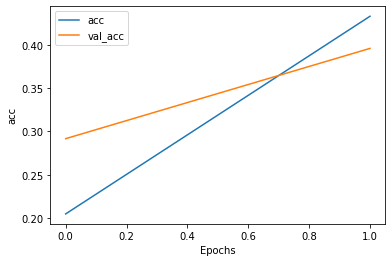

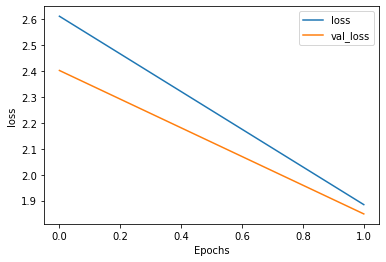

In [ ]:
plot_graphs(history_vgg16,'ac nhic')
plot_graphs(history_vgg16,'loss')

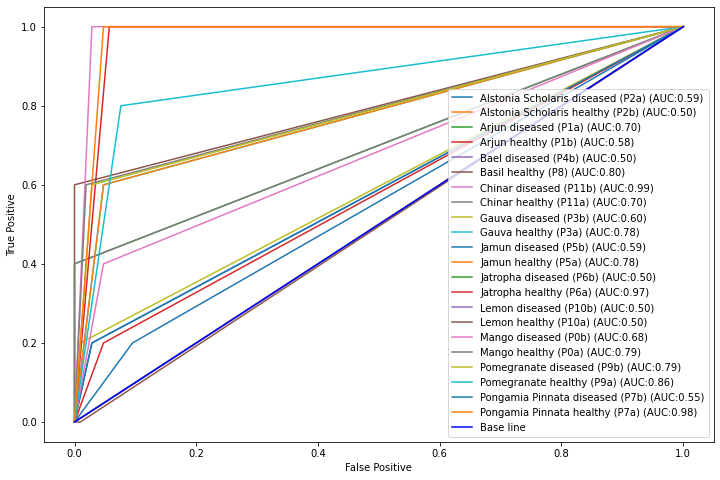

ROC AUC score: 0.6904761904761906


In [ ]:
plot_auc_curve(test_generator, y_pred_vgg16)

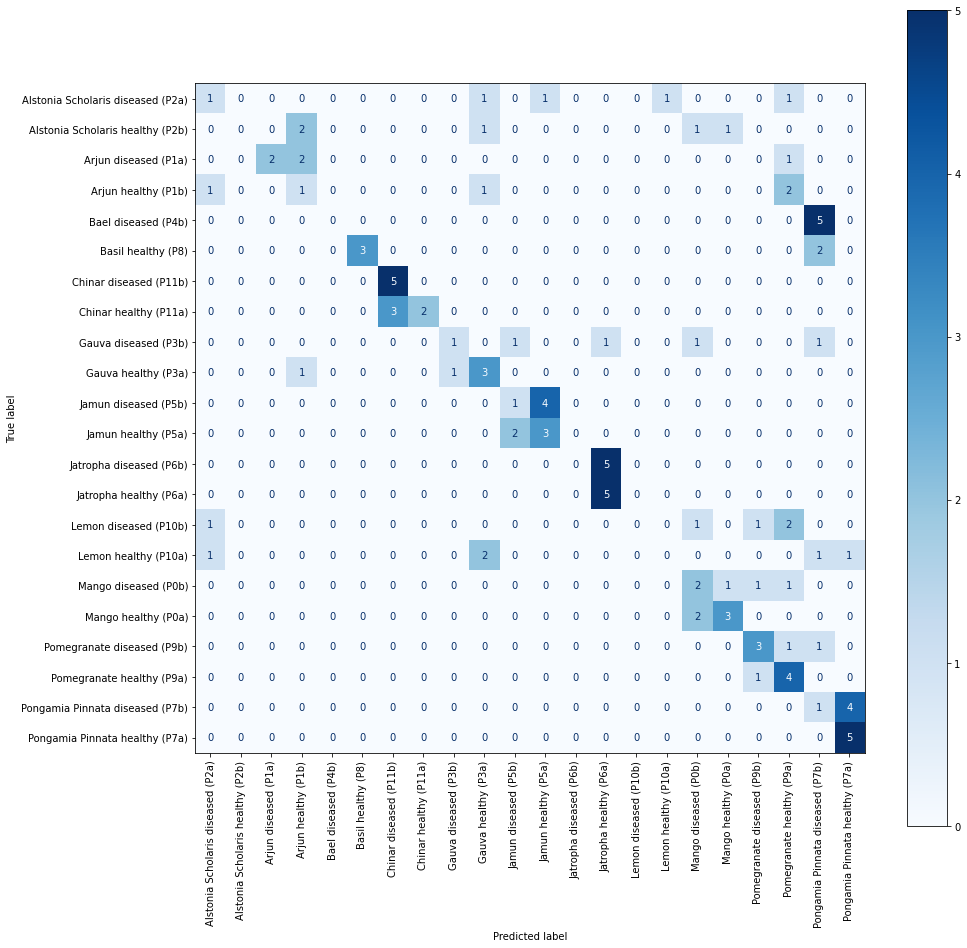

In [ ]:
confusion_matrix(test_generator, y_pred_vgg16)

In [ ]:
report_model(test_generator, y_pred_vgg16)

                                   precision    recall  f1-score   support

Alstonia Scholaris diseased (P2a)       0.25      0.20      0.22         5
 Alstonia Scholaris healthy (P2b)       0.00      0.00      0.00         5
             Arjun diseased (P1a)       1.00      0.40      0.57         5
              Arjun healthy (P1b)       0.17      0.20      0.18         5
              Bael diseased (P4b)       0.00      0.00      0.00         5
               Basil healthy (P8)       1.00      0.60      0.75         5
           Chinar diseased (P11b)       0.62      1.00      0.77         5
            Chinar healthy (P11a)       1.00      0.40      0.57         5
             Gauva diseased (P3b)       0.50      0.20      0.29         5
              Gauva healthy (P3a)       0.38      0.60      0.46         5
             Jamun diseased (P5b)       0.25      0.20      0.22         5
              Jamun healthy (P5a)       0.38      0.60      0.46         5
          Jatropha disea

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_folder(test_path, model):
  for image_name in os.listdir(test_path):
    image_path = os.path.join(test_path, image_name)
    im = Image.open(image_path).resize((224,224))
    plt.title(image_name)
    plt.imshow(np.asarray(im))
    plt.show()
    im = np.array(im)
    im = im.reshape(-1,224,224,3)
    result = model.predict(im/255)
    predicted_class_indices=np.argmax(result,axis=1)
    labels = {'Alstonia Scholaris diseased (P2a)': 0, 'Alstonia Scholaris healthy (P2b)': 1,
              'Arjun diseased (P1a)': 2, 'Arjun healthy (P1b)': 3, 'Bael diseased (P4b)': 4,
              'Basil healthy (P8)': 5, 'Chinar diseased (P11b)': 6, 'Chinar healthy (P11a)': 7,
              'Gauva diseased (P3b)': 8, 'Gauva healthy (P3a)': 9, 'Jamun diseased (P5b)': 10,
              'Jamun healthy (P5a)': 11, 'Jatropha diseased (P6b)': 12, 'Jatropha healthy (P6a)': 13,
              'Lemon diseased (P10b)': 14, 'Lemon healthy (P10a)': 15, 'Mango diseased (P0b)': 16,
              'Mango healthy (P0a)': 17, 'Pomegranate diseased (P9b)': 18, 'Pomegranate healthy (P9a)': 19,
              'Pongamia Pinnata diseased (P7b)': 20, 'Pongamia Pinnata healthy (P7a)': 21}

    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("Image:", image_name)
    print("Predicted class:", predictions[0])

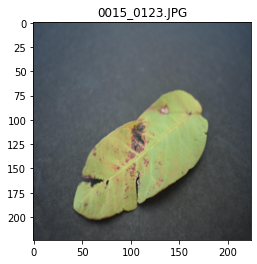

Image: 0015_0123.JPG
Predicted class: Arjun diseased (P1a)


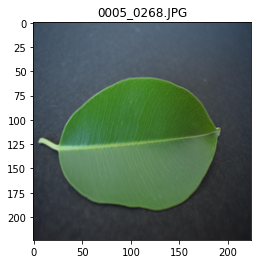

Image: 0005_0268.JPG
Predicted class: Jamun healthy (P5a)


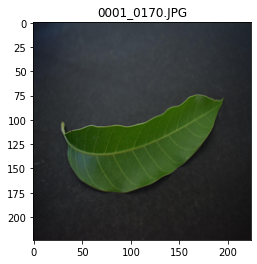

Image: 0001_0170.JPG
Predicted class: Mango diseased (P0b)


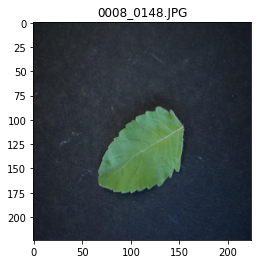

Image: 0008_0148.JPG
Predicted class: Pongamia Pinnata diseased (P7b)


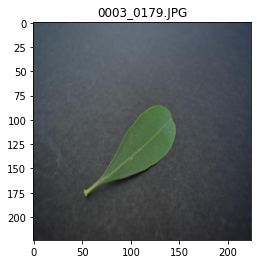

Image: 0003_0179.JPG
Predicted class: Pomegranate healthy (P9a)


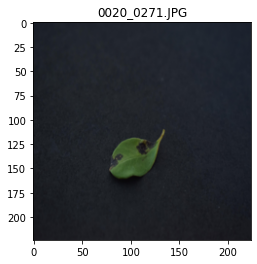

Image: 0020_0271.JPG
Predicted class: Pomegranate healthy (P9a)


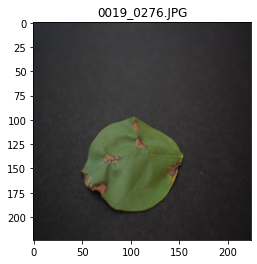

Image: 0019_0276.JPG
Predicted class: Pongamia Pinnata diseased (P7b)


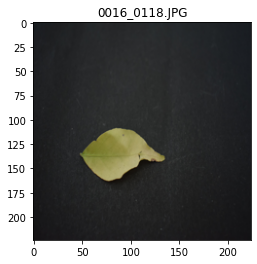

Image: 0016_0118.JPG
Predicted class: Pomegranate healthy (P9a)


In [ ]:
test_path = "/content/drive/MyDrive/FL/plant_disease/Plants_2/images to predict"
predict_folder(test_path, model_vgg16)

# ResNet50

In [ ]:
pre_train_model_ResNet50 = ResNet50(
    include_top = False,
    weights = "imagenet",
    input_shape = (img_width, img_height, 3)
)

model_resnet50 = CreateModel(pre_train_model_ResNet50, "ResNet50")
history_resnet50, model_resnet50 = model_resnet50.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=2)

Epoch 1/2
130/130 [==============================] - 1226s 9s/step - loss: 3.0882 - acc: 0.0685 - val_loss: 3.0987 - val_acc: 0.0521
Epoch 2/2
130/130 [==============================] - 1218s 9s/step - loss: 2.9977 - acc: 0.1060 - val_loss: 3.1548 - val_acc: 0.0521


In [ ]:
y_pred_tmp = model_resnet50.predict(test_generator, step_size_test)
y_pred_resnet50 = np.argmax(y_pred_tmp, axis=1)

In [ ]:
#test model
loss= model_resnet50.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

110/110 [==============================] - 32s 289ms/step - loss: 3.1052 - acc: 0.0455
loss test: 3.11
accuracy test: 0.05


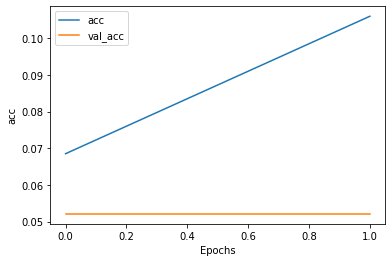

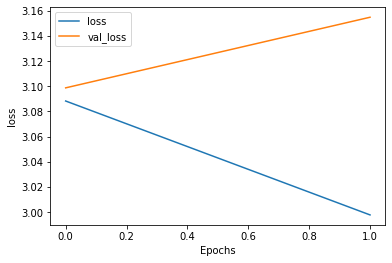

In [ ]:
plot_graphs(history_resnet50,'acc')
plot_graphs(history_resnet50,'loss')

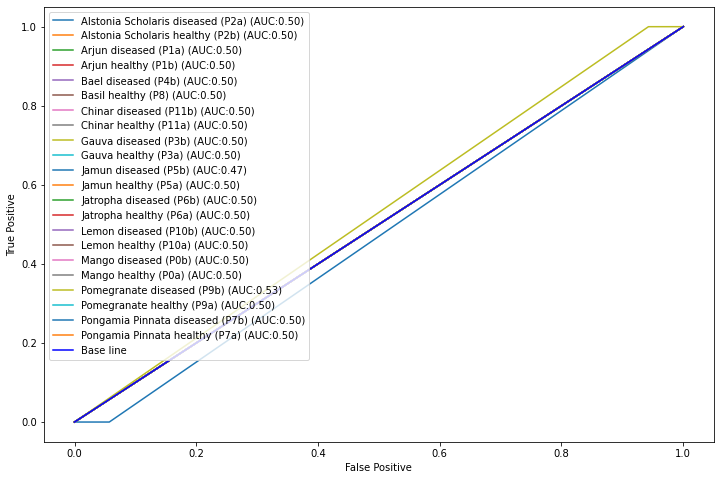

ROC AUC score: 0.5


In [ ]:
plot_auc_curve(test_generator, y_pred_resnet50)

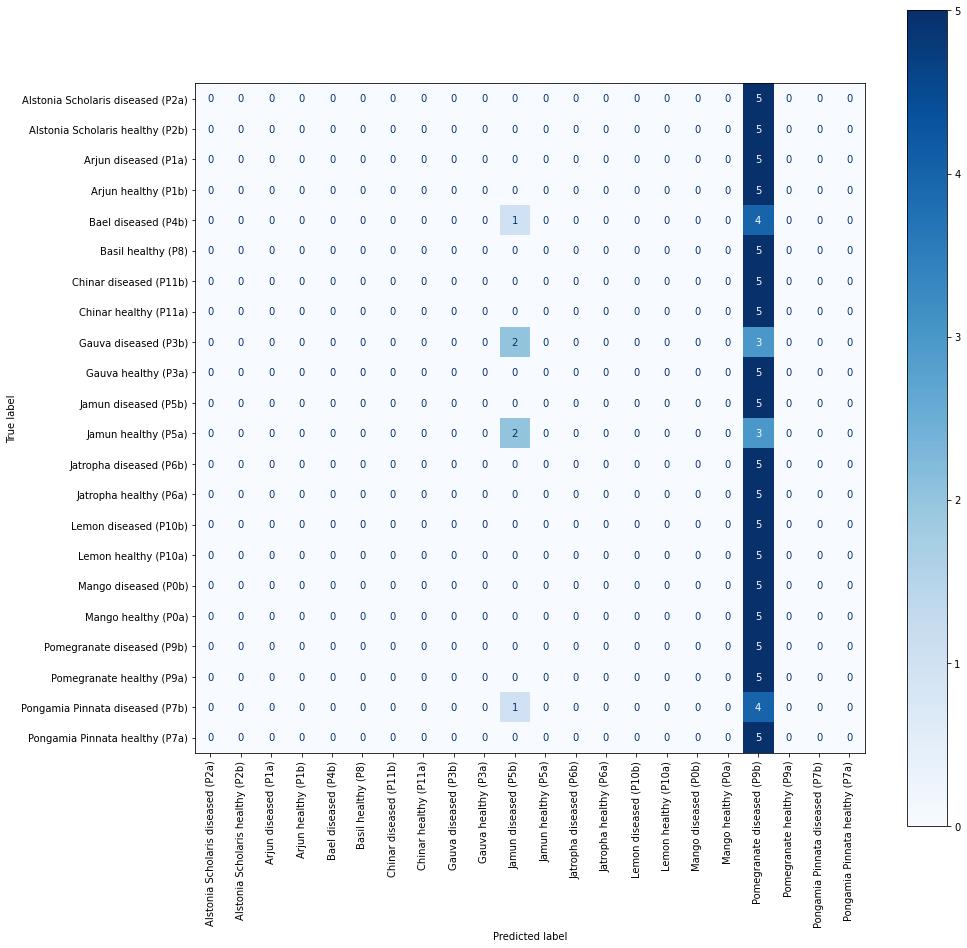

In [ ]:
confusion_matrix(test_generator, y_pred_resnet50)

In [ ]:
report_model(test_generator, y_pred_resnet50)

                                   precision    recall  f1-score   support

Alstonia Scholaris diseased (P2a)       0.00      0.00      0.00         5
 Alstonia Scholaris healthy (P2b)       0.00      0.00      0.00         5
             Arjun diseased (P1a)       0.00      0.00      0.00         5
              Arjun healthy (P1b)       0.00      0.00      0.00         5
              Bael diseased (P4b)       0.00      0.00      0.00         5
               Basil healthy (P8)       0.00      0.00      0.00         5
           Chinar diseased (P11b)       0.00      0.00      0.00         5
            Chinar healthy (P11a)       0.00      0.00      0.00         5
             Gauva diseased (P3b)       0.00      0.00      0.00         5
              Gauva healthy (P3a)       0.00      0.00      0.00         5
             Jamun diseased (P5b)       0.00      0.00      0.00         5
              Jamun healthy (P5a)       0.00      0.00      0.00         5
          Jatropha disea

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


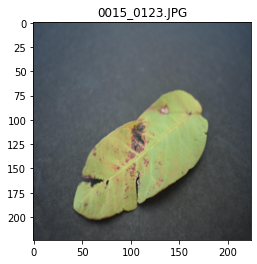

Image: 0015_0123.JPG
Predicted class: Pomegranate diseased (P9b)


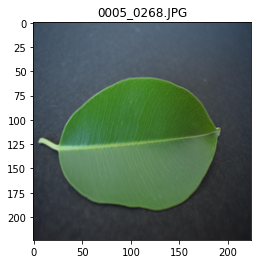

Image: 0005_0268.JPG
Predicted class: Pomegranate diseased (P9b)


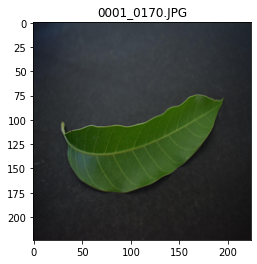

Image: 0001_0170.JPG
Predicted class: Pomegranate diseased (P9b)


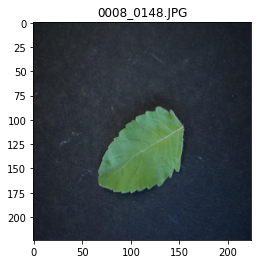

Image: 0008_0148.JPG
Predicted class: Pomegranate diseased (P9b)


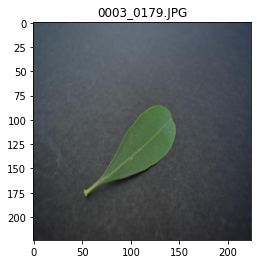

Image: 0003_0179.JPG
Predicted class: Pomegranate diseased (P9b)


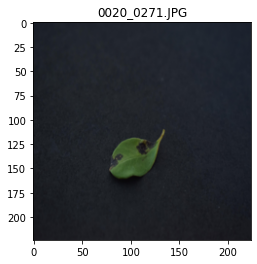

Image: 0020_0271.JPG
Predicted class: Pomegranate diseased (P9b)


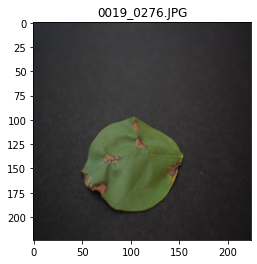

Image: 0019_0276.JPG
Predicted class: Pomegranate diseased (P9b)


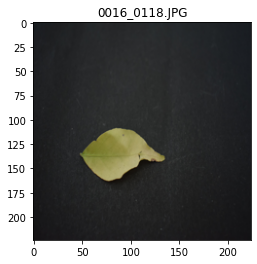

Image: 0016_0118.JPG
Predicted class: Pomegranate diseased (P9b)


In [ ]:
test_path = "/content/drive/MyDrive/FL/plant_disease/Plants_2/images to predict"
predict_folder(test_path, model_resnet50)

# MobileNet

In [ ]:
pre_train_model_MobileNet = MobileNet(
    include_top = False,
    weights = "imagenet",
    input_shape = (img_width, img_height, 3)
)

model_mobilenet = CreateModel(pre_train_model_MobileNet, "MobileNet")
history_mobilenet, model_mobilenet = model_mobilenet.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=2)

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/2
130/130 [==============================] - 1227s 9s/step - loss: 1.9006 - acc: 0.4389 - val_loss: 1.3579 - val_acc: 0.5625
Epoch 2/2
130/130 [==============================] - 1215s 9s/step - loss: 0.9710 - acc: 0.7012 - val_loss: 0.8069 - val_acc: 0.7188


In [ ]:
y_pred_tmp = model_mobilenet.predict(test_generator, step_size_test)
y_pred_mobilenet = np.argmax(y_pred_tmp, axis=1)

In [ ]:
#test model
loss= model_mobilenet.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

110/110 [==============================] - 31s 282ms/step - loss: 0.7259 - acc: 0.7818
loss test: 0.73
accuracy test: 0.78


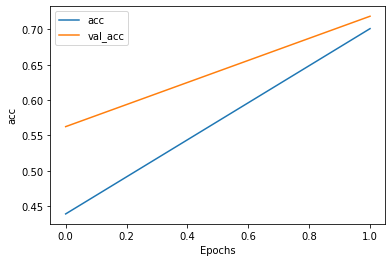

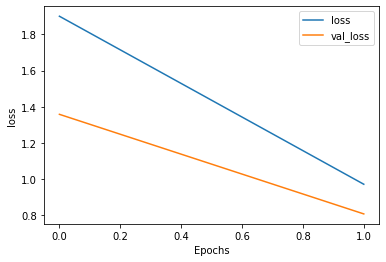

In [ ]:
plot_graphs(history_mobilenet,'acc')
plot_graphs(history_mobilenet,'loss')

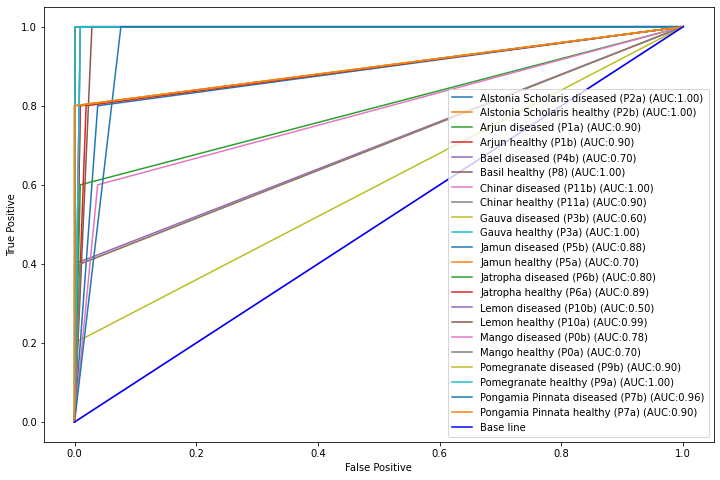

ROC AUC score: 0.861904761904762


In [ ]:
plot_auc_curve(test_generator, y_pred_mobilenet)

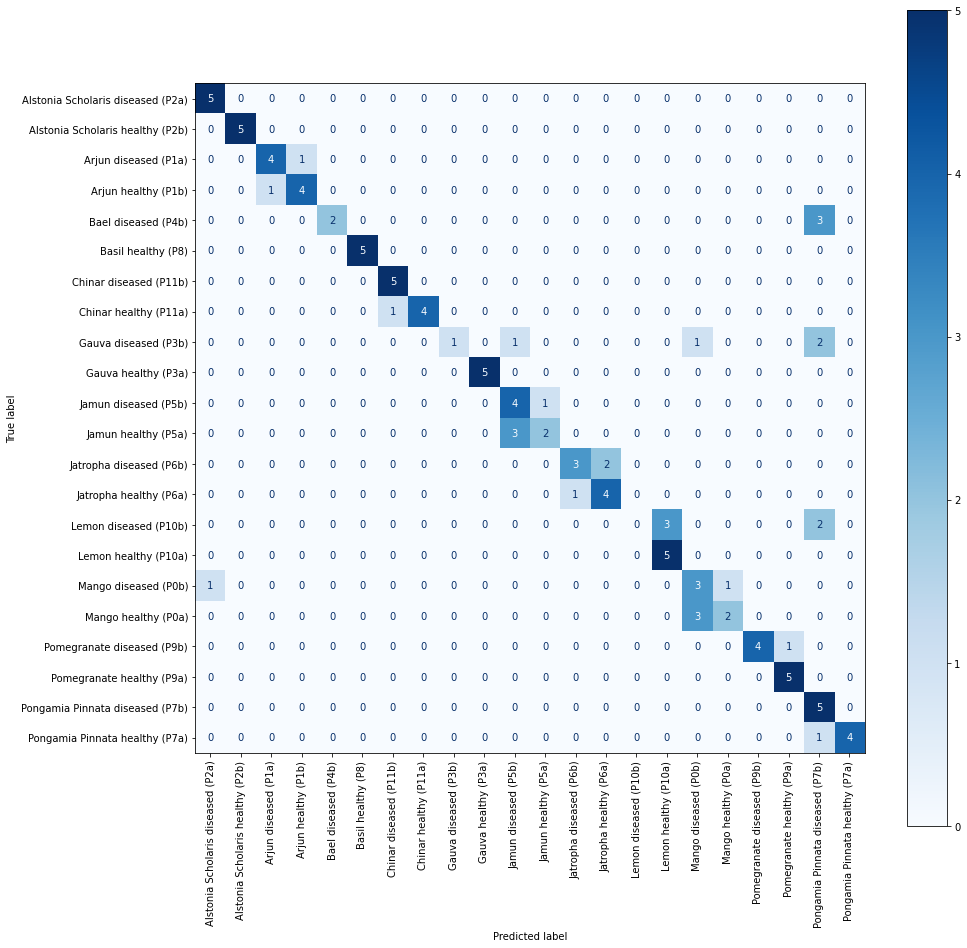

In [ ]:
confusion_matrix(test_generator, y_pred_mobilenet)

In [ ]:
report_model(test_generator, y_pred_mobilenet)

                                   precision    recall  f1-score   support

Alstonia Scholaris diseased (P2a)       0.83      1.00      0.91         5
 Alstonia Scholaris healthy (P2b)       1.00      1.00      1.00         5
             Arjun diseased (P1a)       0.80      0.80      0.80         5
              Arjun healthy (P1b)       0.80      0.80      0.80         5
              Bael diseased (P4b)       1.00      0.40      0.57         5
               Basil healthy (P8)       1.00      1.00      1.00         5
           Chinar diseased (P11b)       0.83      1.00      0.91         5
            Chinar healthy (P11a)       1.00      0.80      0.89         5
             Gauva diseased (P3b)       1.00      0.20      0.33         5
              Gauva healthy (P3a)       1.00      1.00      1.00         5
             Jamun diseased (P5b)       0.50      0.80      0.62         5
              Jamun healthy (P5a)       0.67      0.40      0.50         5
          Jatropha disea

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


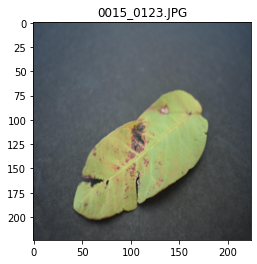

Image: 0015_0123.JPG
Predicted class: Gauva diseased (P3b)


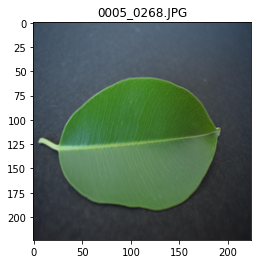

Image: 0005_0268.JPG
Predicted class: Jamun healthy (P5a)


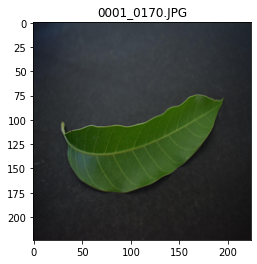

Image: 0001_0170.JPG
Predicted class: Mango diseased (P0b)


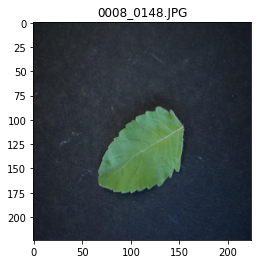

Image: 0008_0148.JPG
Predicted class: Basil healthy (P8)


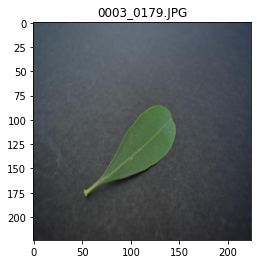

Image: 0003_0179.JPG
Predicted class: Alstonia Scholaris healthy (P2b)


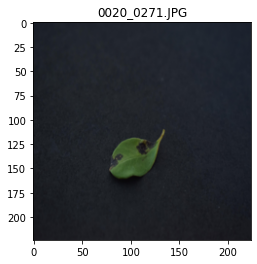

Image: 0020_0271.JPG
Predicted class: Pomegranate diseased (P9b)


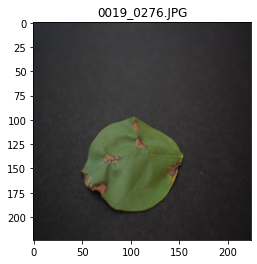

Image: 0019_0276.JPG
Predicted class: Pongamia Pinnata diseased (P7b)


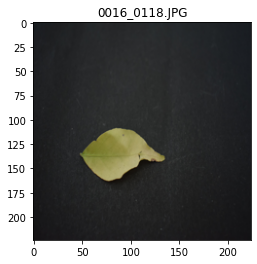

Image: 0016_0118.JPG
Predicted class: Bael diseased (P4b)


In [ ]:
test_path = "/content/drive/MyDrive/FL/plant_disease/Plants_2/images to predict"
predict_folder(test_path, model_mobilenet)

# InceptionV3

In [ ]:
pre_train_model_InceptionV3 = InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = (img_width, img_height, 3)
)

model_inceptionv3 = CreateModel(pre_train_model_InceptionV3, "InceptionV3")
history_inceptionv3, model_inceptionv3 = model_inceptionv3.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=2)

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/2
 10/130 [=>............................] - ETA: 18:00 - loss: 3.0737 - acc: 0.1063

In [ ]:
y_pred_tmp = model_inceptionv3.predict(test_generator, step_size_test)
y_pred_inceptionv3 = np.argmax(y_pred_tmp, axis=1)

In [ ]:
#test model
loss= model_inceptionv3.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

In [ ]:
plot_graphs(history_inceptionv3,'acc')
plot_graphs(history_inceptionv3,'loss')

In [ ]:
plot_auc_curve(test_generator, y_pred_inceptionv3)

In [ ]:
confusion_matrix(test_generator, y_pred_inceptionv3)

In [ ]:
report_model(test_generator, y_pred_inceptionv3)

In [ ]:
test_path = "/content/drive/MyDrive/FL/plant_disease/Plants_2/images to predict"
predict_folder(test_path, model_inceptionv3)

# EfficientNetB1

In [ ]:
pre_train_model_EfficientNetB1 = EfficientNetB1(
    include_top = False,
    weights = "imagenet",
    input_shape = (img_width, img_height, 3)
)

model_efficientnetb1 = CreateModel(pre_train_model_EfficientNetB1, "EfficientNetB1")
history_efficientnetb1, model_efficientnetb1 = model_efficientnetb1.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=2)

In [ ]:
y_pred_tmp = model_efficientnetb1.predict(test_generator, step_size_test)
y_pred_efficientnetb1 = np.argmax(y_pred_tmp, axis=1)

In [ ]:
#test model
loss= model_efficientnetb1.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

In [ ]:
plot_graphs(history_efficientnetb1,'acc')
plot_graphs(history_efficientnetb1,'loss')

In [ ]:
plot_auc_curve(test_generator, y_pred_efficientnetb1)

In [ ]:
confusion_matrix(test_generator, y_pred_efficientnetb1)

In [ ]:
report_model(test_generator, y_pred_efficientnetb1)

In [ ]:
test_path = "/content/drive/MyDrive/FL/plant_disease/Plants_2/images to predict"
predict_folder(test_path, model_efficientnetb1)